In [1]:
import os
import dill
import bilby
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

from util import (
    plot_single_evolution, violinplot, plot_multiple_lower_dim, dpi_key_to_label, dpi_keys,
    HYBRID_INIT_COLOR, HYBRID_COLOR, HYBRID_OVERLAP0_COLOR, COMP_COLOR, HYBRID_EVOL_COLORS
)

%load_ext autoreload
%autoreload 2

plt.style.use("./tgr-hybrid-sampling.mplstyle")

In [2]:
### relevant injected values
dpi_vals = { key : 0 for key in dpi_keys }
dpi_vals['d_phi_2'] = 0.2

chirp_mass = 30
mass_ratio = 0.8

# Load Data

## Read Hybrid Results

In [3]:
dpi_runs = dict()

for overlap in ["0.0", "0.9"]:
    for dpi in dpi_vals.keys():
        
        if float(overlap) == 0:
            hdf_path = "./data/bgr_results/injection_hybrid_step2_no-overlap.hdf5"
        else:
            hdf_path = "./data/bgr_results/injection_hybrid_step2.hdf5"

        posterior = pd.read_hdf(hdf_path, key=dpi)
        dpi_runs[(dpi, overlap, "hybrid")] = bilby.core.result.Result(
            posterior = posterior,
            search_parameter_keys = list( posterior.columns ),
            samples = posterior.values
        )
        

## Read `dynesty`-only result

In [4]:
for dpi in dpi_vals.keys():
    posterior = pd.read_hdf("./data/bgr_results/injection_direct.hdf5", key=dpi)
    
    dpi_runs[(dpi, "0.0", "comp")] = bilby.core.result.Result(
        posterior = posterior,
        search_parameter_keys = list( posterior.columns ),
        samples = posterior.values
    )
        

# Instrinsic + Extrinsic Corner Plot for $\delta \varphi_2$ Analysis (Figure 10)

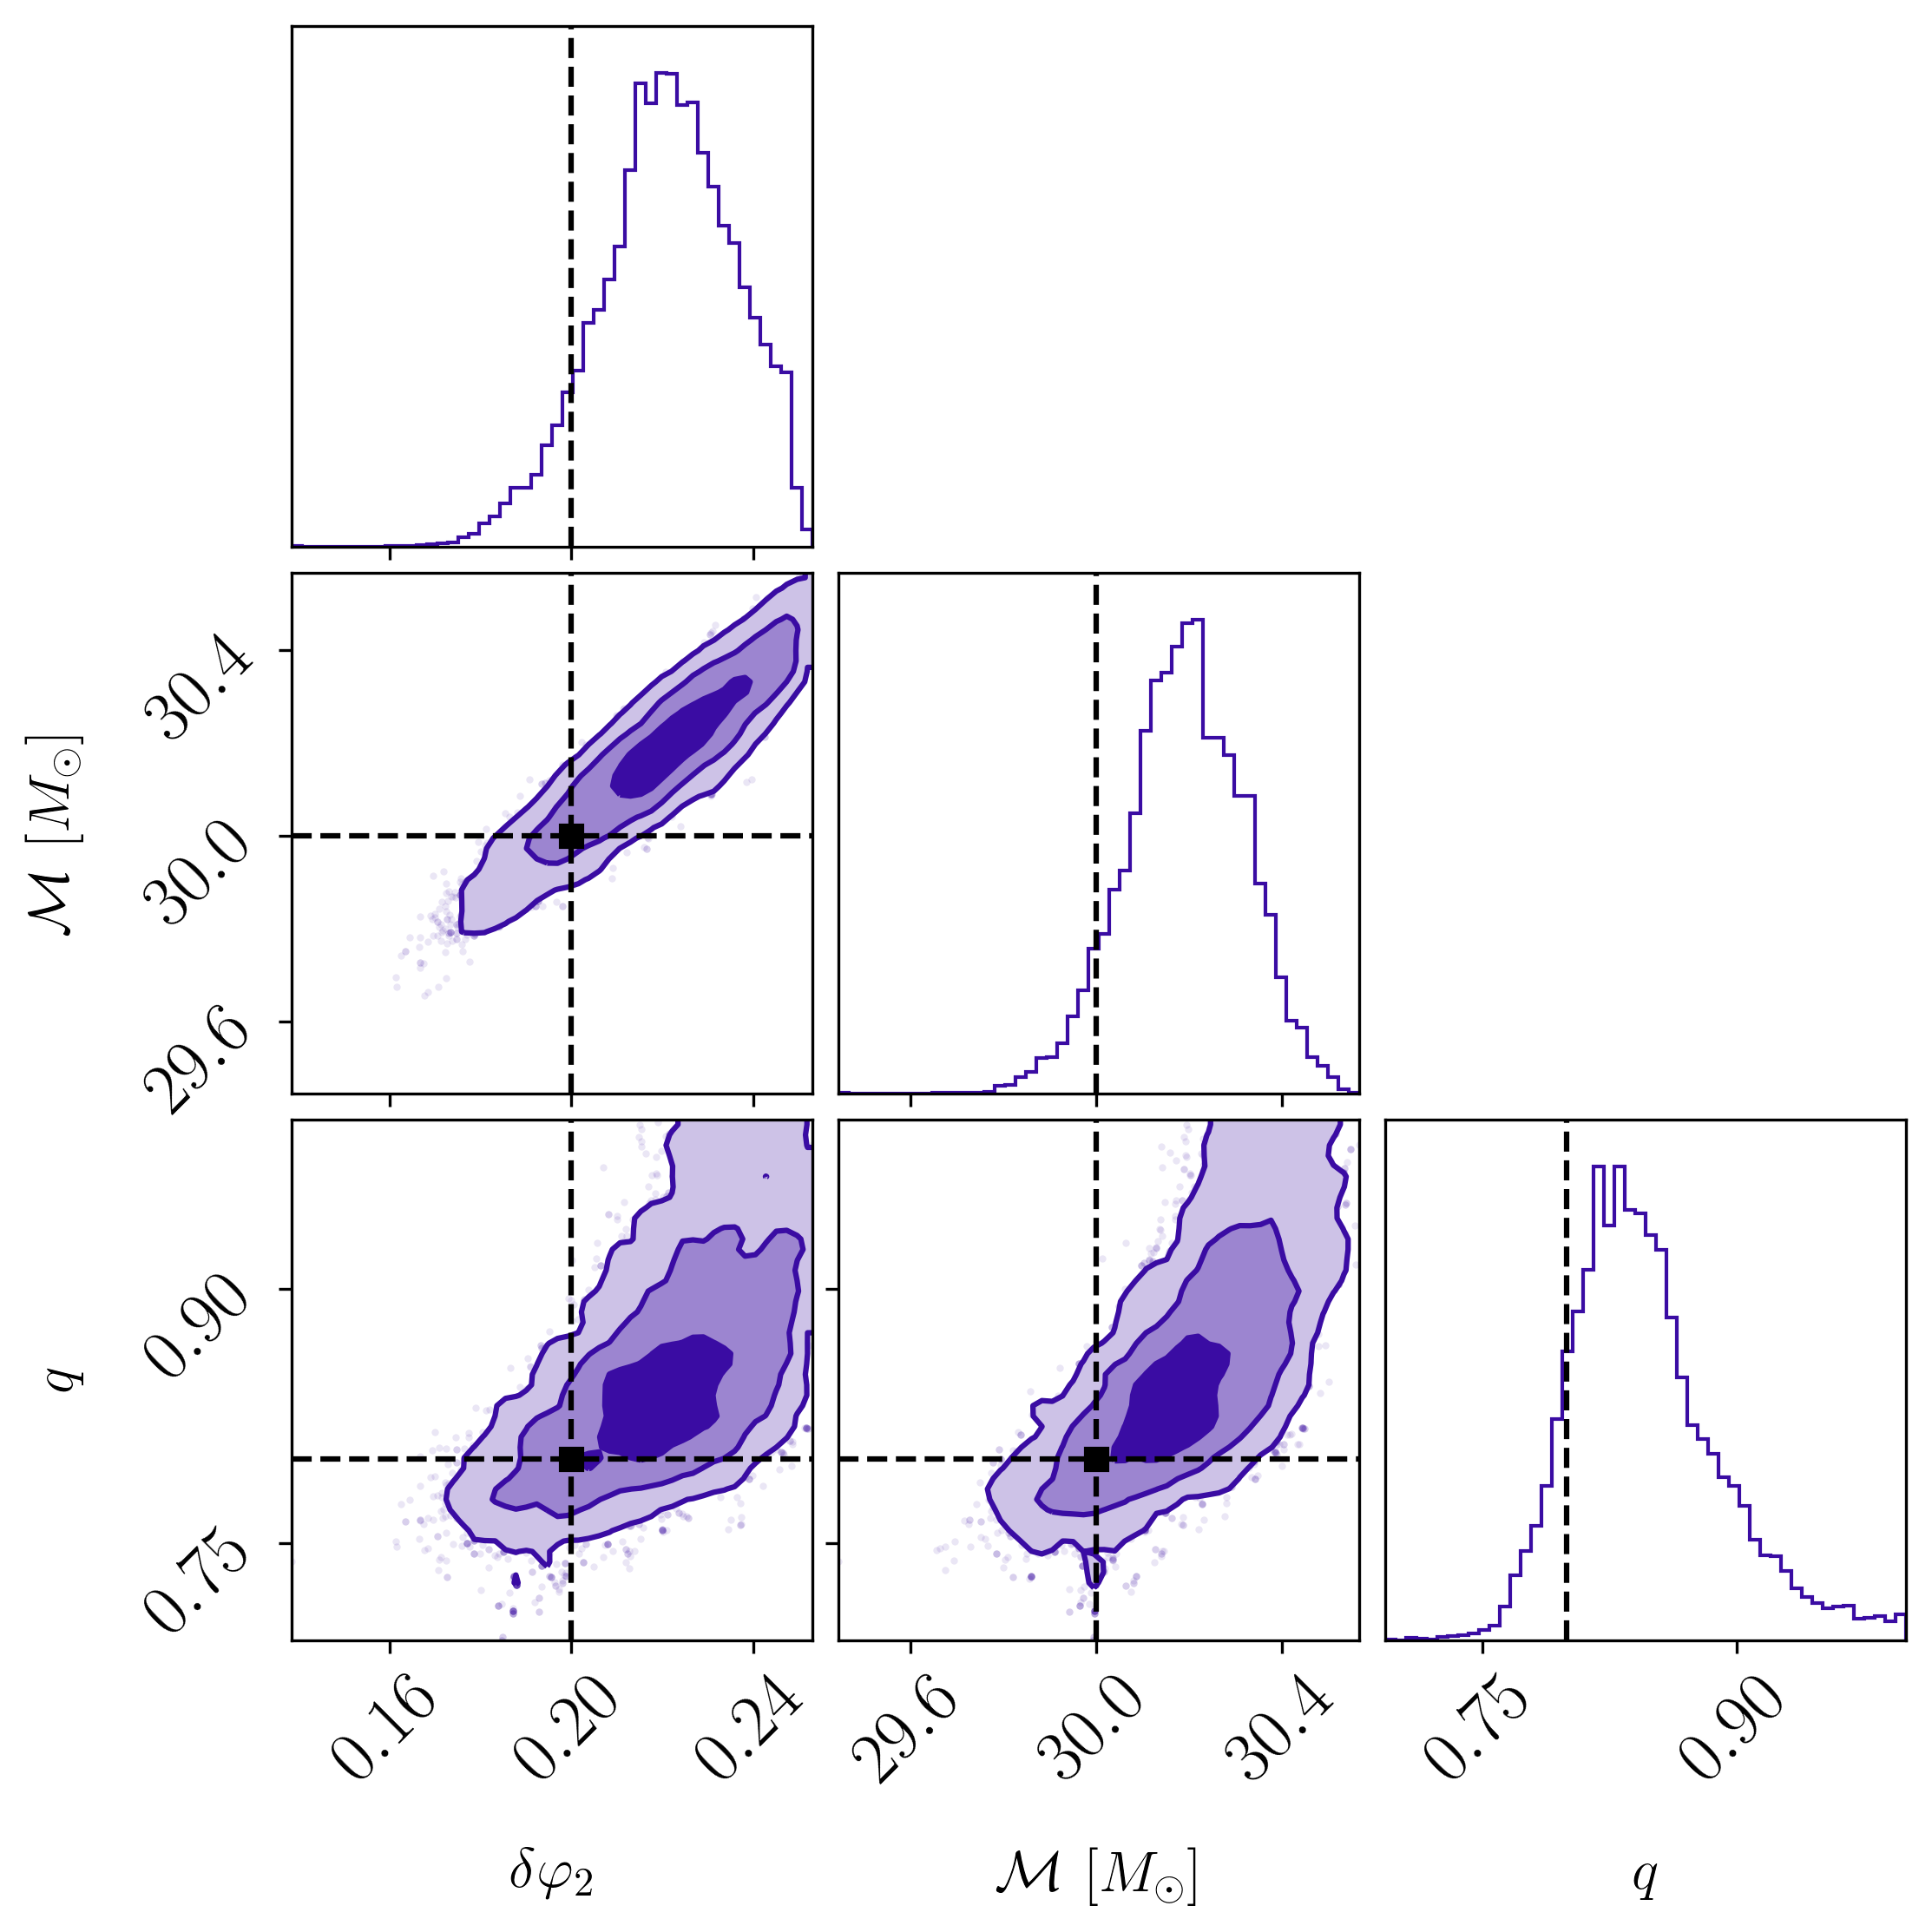

In [6]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = dpi_runs[("d_phi_2", "0.9", "hybrid")].plot_corner(
        parameters = dict(
            d_phi_2 = dpi_vals["d_phi_2"],
            chirp_mass = chirp_mass,
            mass_ratio = mass_ratio,
        ),
        labels = [
            dpi_key_to_label("d_phi_2"),
            r"$\mathcal{M}$ [$M_{\odot}$]", 
            r"$q$",
        ],
        color = HYBRID_COLOR,
        truth_color = "black",
        titles = False,
        quantiles = None,
        labelpad = 0.1
    )

fig.savefig("./figures/highsnr_corner.pdf", bbox_inches="tight")

# Sampling Evolution (Figure 11)

In [7]:
with open("./data/bgr_results/injection_d_phi_2_resume.pickle", "rb") as f:
    resume_dphi2 = dill.load(f)

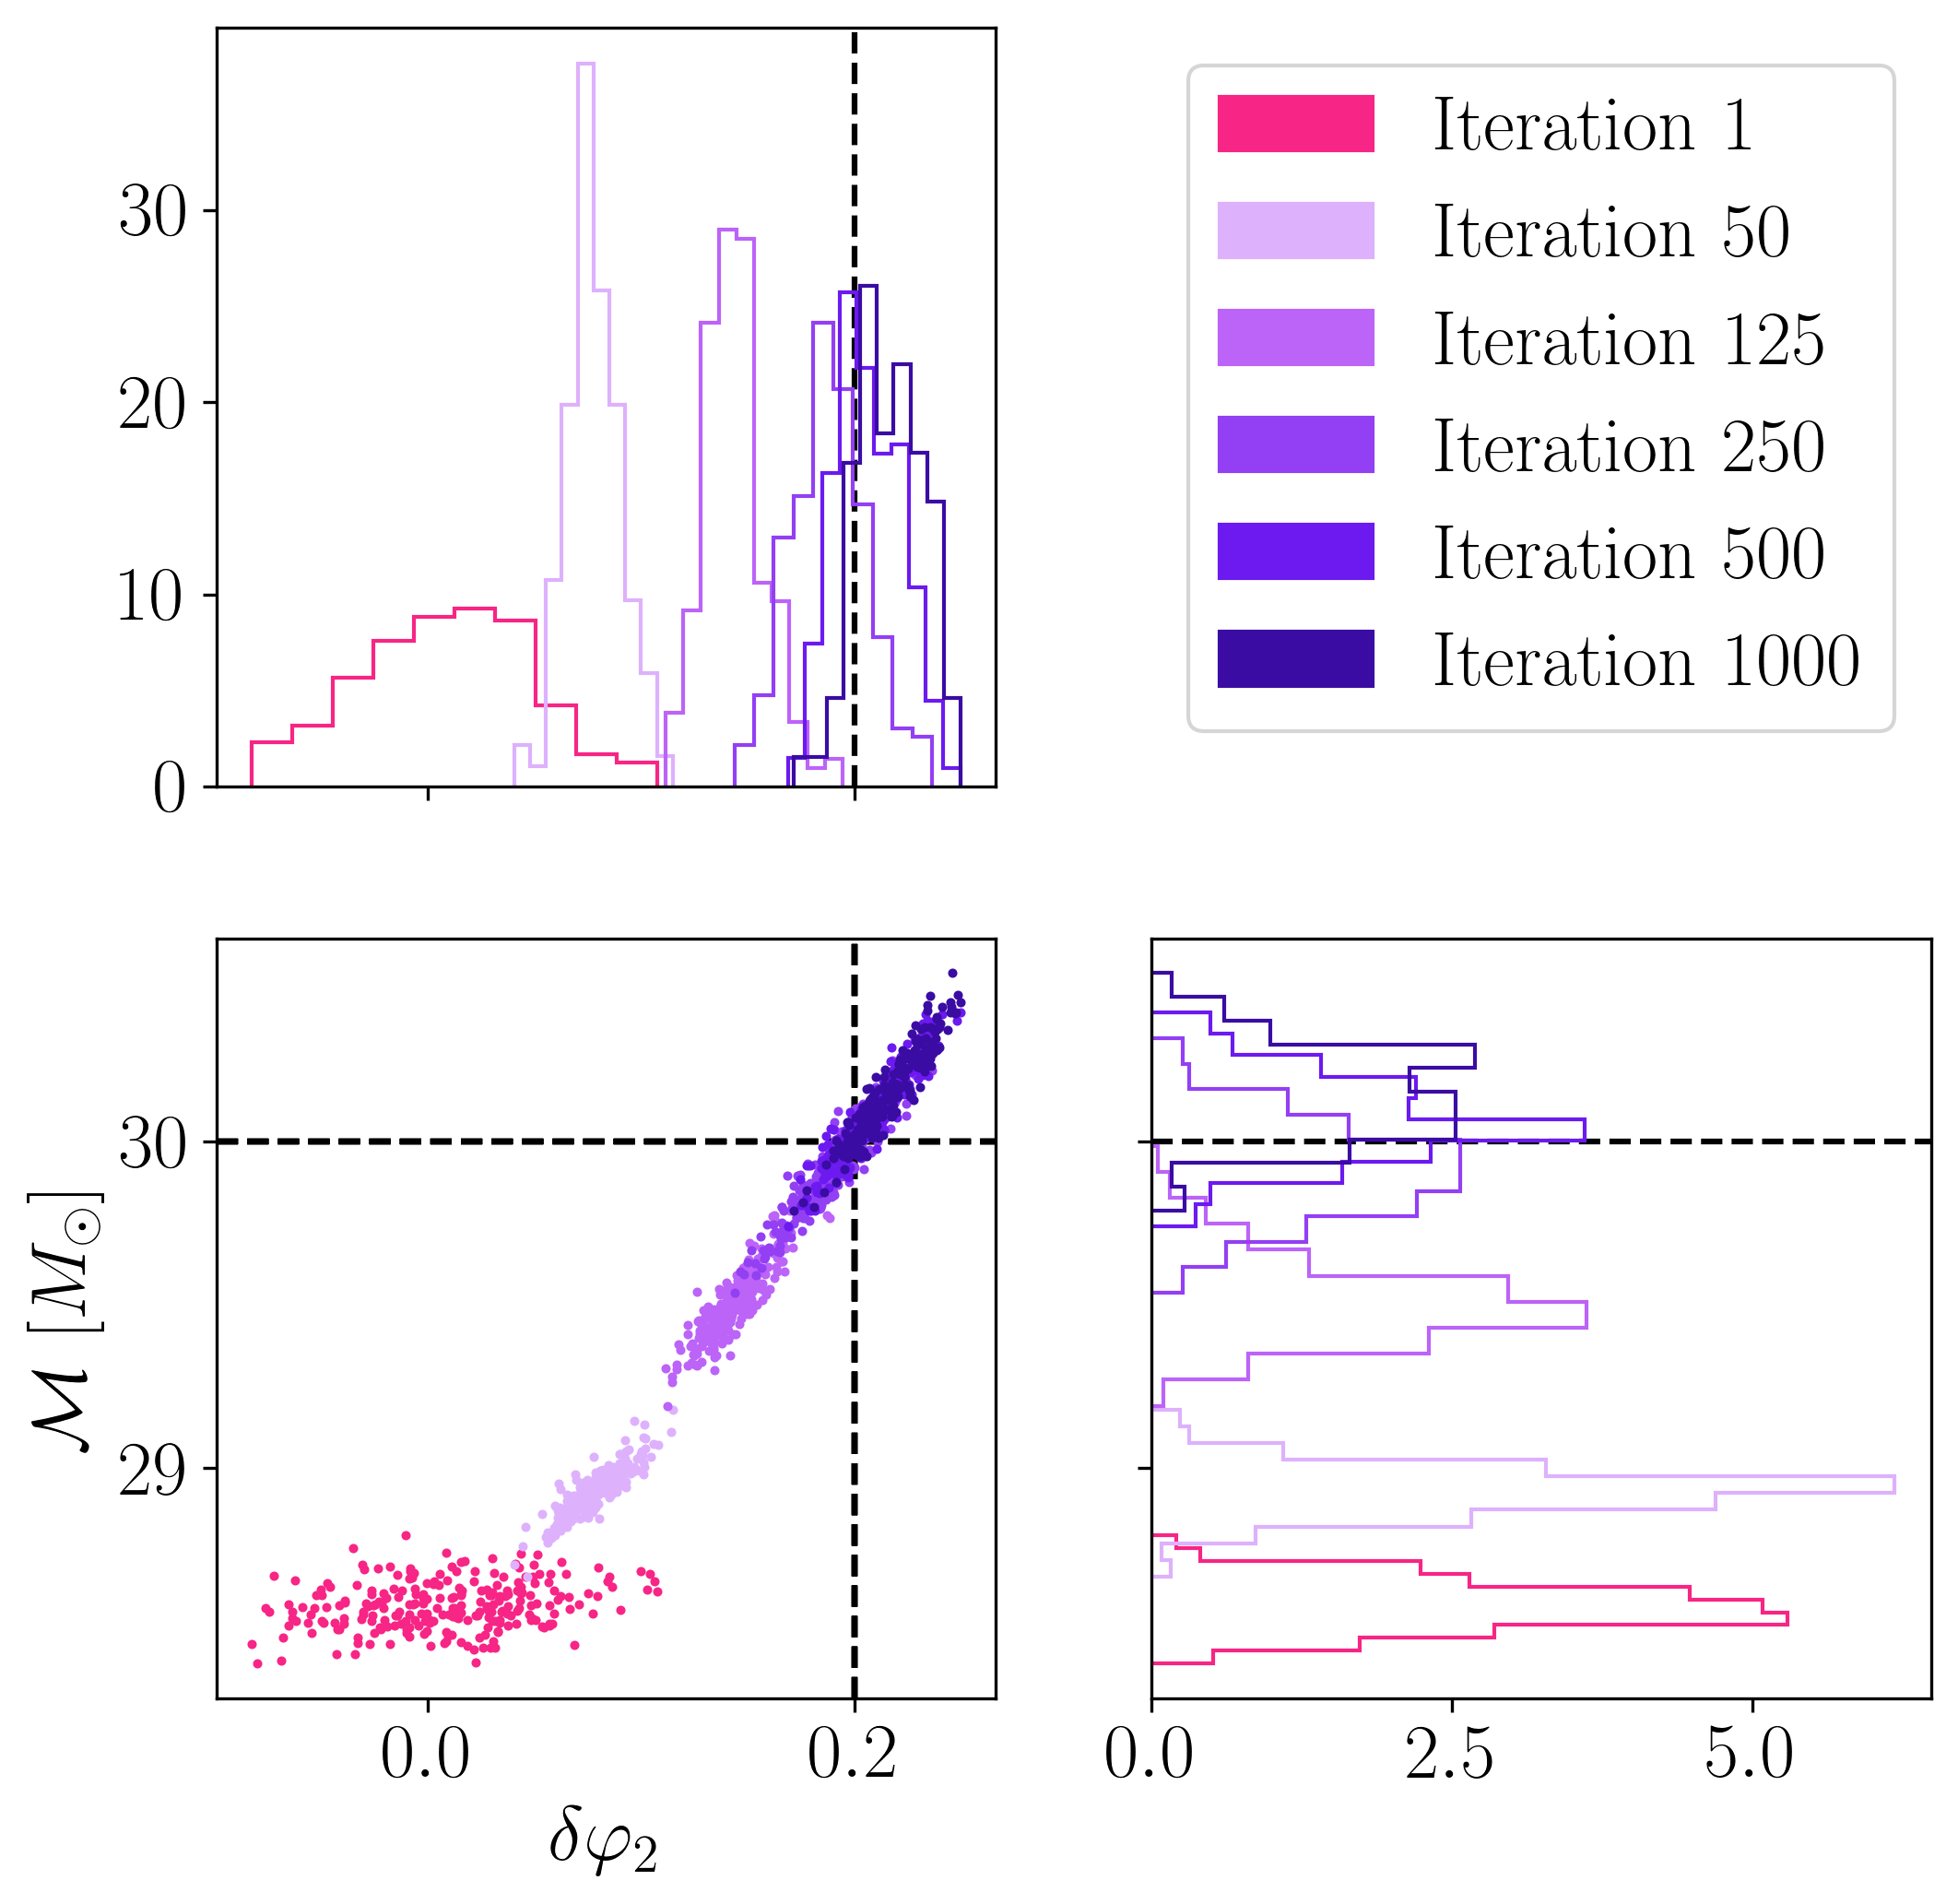

In [8]:
iterations = [1, 50, 125, 250, 500, 1000]

fig = plot_single_evolution(
    dpi_runs["d_phi_2", "0.9", "hybrid"], resume_dphi2, 
    "d_phi_2", "chirp_mass", 
    r"$\delta \varphi_2$", r"$\mathcal{M}$ [$M_{\odot}$]",
    iterations = np.array(iterations) - 1,
    xtrue=dpi_vals["d_phi_2"], ytrue=chirp_mass,
    xidx_override = 10
)

fig.get_axes()[1].legend(
    [ 
        mpl.patches.Patch(facecolor=c, edgecolor=c) 
        for c in [HYBRID_INIT_COLOR] + HYBRID_EVOL_COLORS[:len(iterations) - 1] ] + [ mpl.patches.Patch(facecolor="#FF8C00", edgecolor="#FF8C00") 
    ],
    [ f"Iteration %d" % it for it in iterations ],
    loc = "upper center"
)

fig.savefig("./figures/injection_evolution_d_phi_2.pdf", bbox_inches="tight")

# Violinplot (Figure 12)

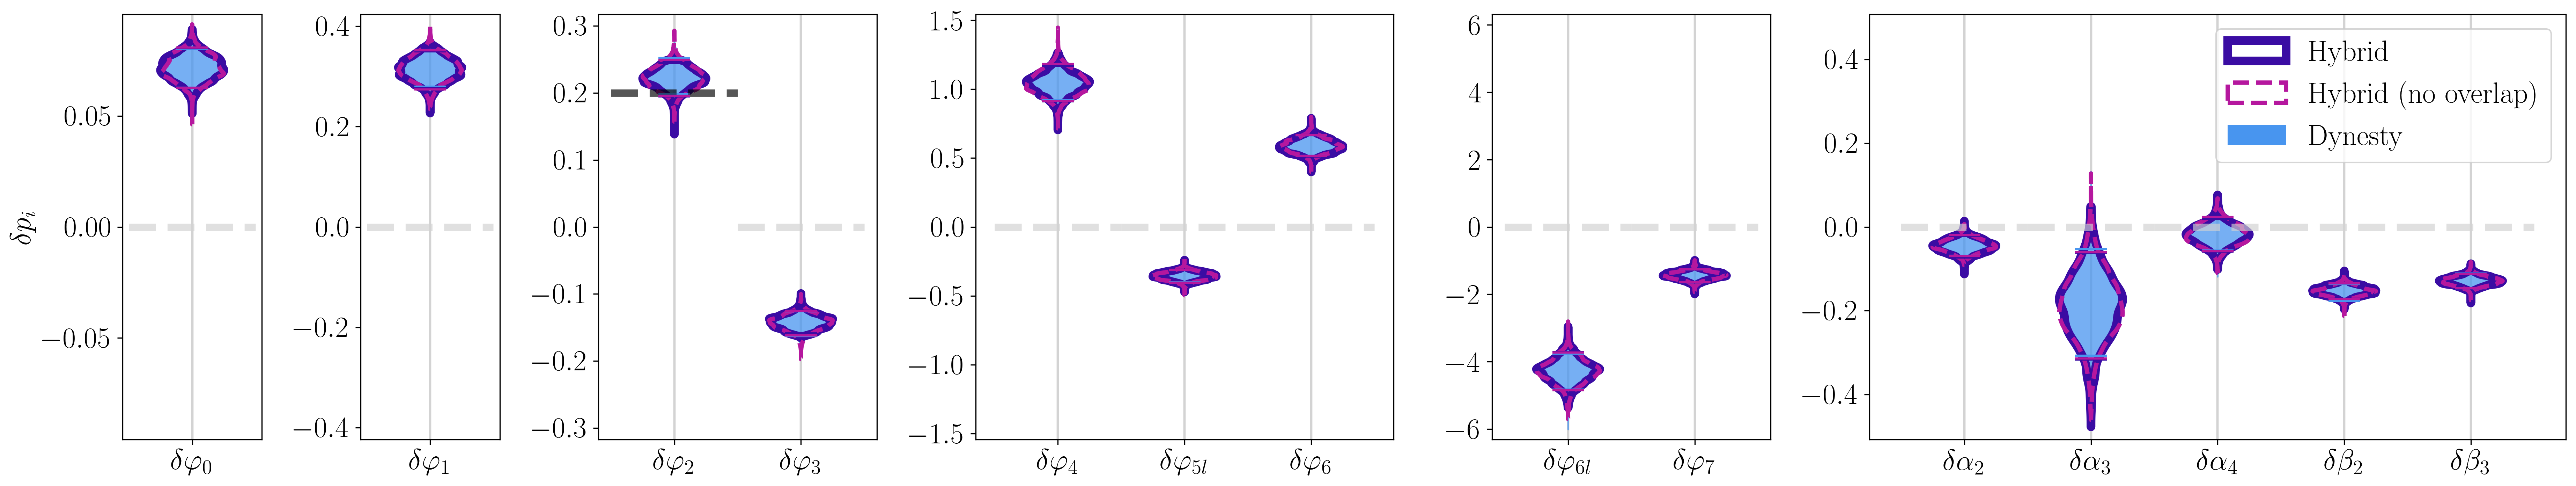

In [9]:
fig, axes = violinplot(
    runs = dpi_runs, 
    param_key = "dpi", 
    truth = dpi_vals, 
    param_label = r"$\delta p_i$",
    labels = [ "Hybrid", "Hybrid (no overlap)", "Dynesty" ],
    fig_kwargs=dict(figsize=(25,5))
)

fig.savefig("./figures/highsnr_violinplot.pdf", bbox_inches="tight")

# Chirp Mass Violinplot (Figure 13)

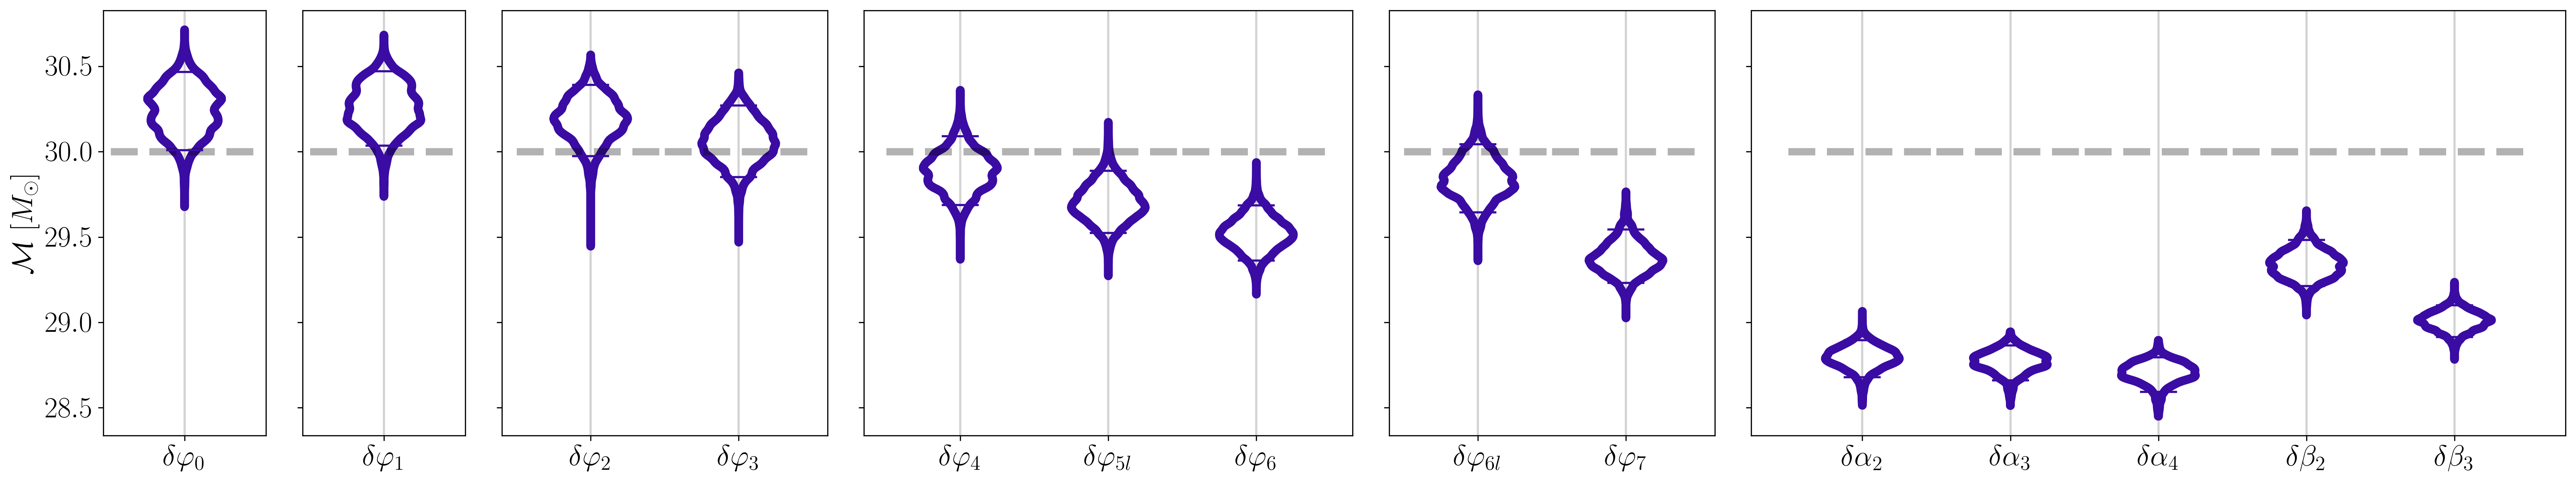

In [10]:
fig, axes = violinplot(
    runs = { k : v for k,v in dpi_runs.items() if k[1] == "0.9" and k[2] == "hybrid" }, 
    param_key = "chirp_mass", truth = chirp_mass, param_label = r"$\mathcal{M}$ [$M_{\odot}$]",
    colors = [ HYBRID_COLOR ], labels = None,
    square_y=False, share_y=True, fig_kwargs=dict(figsize=(25,5)) 
)

fig.savefig("./figures/chirp-mass_violinplot.pdf", bbox_inches="tight")